In [2]:
import numpy as np
import pylab as pl
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib import transforms, colors, image

import sys,petsc4py
petsc4py.init(sys.argv)
from petsc4py import PETSc

%matplotlib inline

pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 25

pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

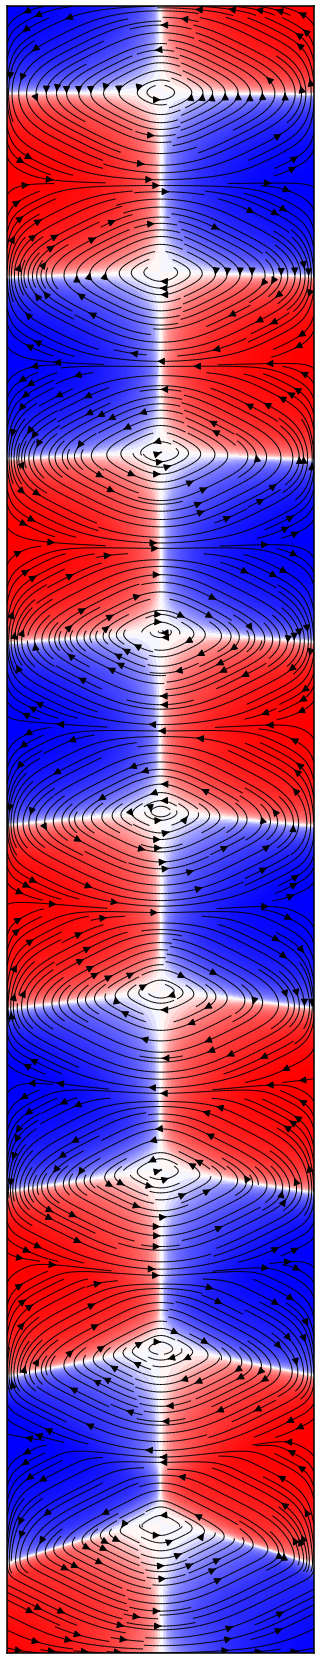

In [3]:
import PetscBinaryIO

io = PetscBinaryIO.PetscBinaryIO()

#filepath = 'gpueater_backup/pdcoo2_data/circ_fermi_surface'
#filename = 't=00000400.000000.bin'

#filepath = 'gpueater_backup/pdcoo2_data/L_1.0_5.25_ballistic_rotated'
#filename = 't=00000400.000000.bin'

filepath = 'gpueater_backup/pdcoo2_data/L_1.0_5.25_ballistic'
filename = 't=00000500.000000.bin'

gamma = 5.0
l = 0.25 + gamma

N_q1 = 40
N_q2 = int(round(N_q1*l))

q1_start = 0.0
q2_start = 0.0
q1_end = 1.0
q2_end = l

pl.figure(figsize=(7.5*1.5, 1.5*25.0*l/6.5))

q1 = q1_start + (0.5 + np.arange(N_q1)) * (q1_end - q1_start)/N_q1
q2 = q2_start + (0.5 + np.arange(N_q2)) * (q2_end - q2_start)/N_q2

q2_meshgrid, q1_meshgrid = np.meshgrid(q2, q1)

moments_file = filepath + '/dump_moments/' + filename
lagrange_multipliers_file = filepath + '/dump_lagrange_multipliers/' + filename

moments = io.readBinaryFile(moments_file)
moments = moments[0].reshape(N_q2, N_q1, 3)

density = moments[:, :, 0]

lagrange_multipliers = io.readBinaryFile(lagrange_multipliers_file)
lagrange_multipliers = lagrange_multipliers[0].reshape(N_q2, N_q1, 5)

mu    = lagrange_multipliers[:, :, 0]
mu_ee = lagrange_multipliers[:, :, 1]
T_ee  = lagrange_multipliers[:, :, 2]
vel_x = lagrange_multipliers[:, :, 3]
vel_y = lagrange_multipliers[:, :, 4]

current_x = density*vel_x
current_y = density*vel_y

base = pl.gca().transData
rot = transforms.Affine2D().rotate_deg(0)

delta_n = density - np.mean(density)

pl.contourf(q1, q2, delta_n, 200,
    norm=colors.SymLogNorm(linthresh=delta_n.max()/20), cmap='bwr',
    transform = rot + base)

pl.streamplot(q1, q2, current_x, current_y,
          density=1.4*l, color='black',
          linewidth=1, arrowsize=1.5, transform = rot + base
         )

pl.yticks([])
pl.xticks([])

pl.xlim([q1[0], q1[-1]])
pl.ylim([q2[0], q2[-1]])

pl.gca().set_aspect('equal')

In [4]:
N_buffer = N_q1

Nx = N_q1 + 2*N_buffer # max : 120
Ny = N_q2 + 2*N_buffer # max : 303
Nz = 4*N_buffer # max : 210

print("Nx, Ny, Nz = ", Nx, Ny, Nz)

# Set these manually to make sure they are divisible by 3 after examining the numbers above

Nx = 120
Ny = 291
Nz = 162

x_index_start = N_buffer
x_index_end   = Nx - N_buffer

y_index_start = N_buffer
y_index_end   = Ny - N_buffer - 1

x_index_start

Nx, Ny, Nz =  120 290 160


40

In [72]:
Ng = 1

dx = dy = dz = .025 # um

x_start = -Nx/2*dx; x_end = Nx/2*dx
y_start = -Ny/2*dy; y_end = Ny/2*dy
z_start = -Nz/2*dz; z_end = Nz/2*dz

mu0  = 1.25663706e-6

def get_local_array(vec, dof):
    return vec.getArray().reshape([Nz_local+2*Ng,
                                   Ny_local+2*Ng,
                                   Nx_local+2*Ng, 
                                   dof
                                  ]
                                 )

def get_global_array(vec, dof):
    return vec.getArray().reshape([Nz_local,
                                   Ny_local,
                                   Nx_local,
                                   dof
                                  ]
                                 )


    
da = PETSc.DMDA().create([Nx, Ny, Nz], dof=1, stencil_width=Ng,
                         boundary_type=['periodic', 'periodic', 'periodic']
                        )

da_aux = PETSc.DMDA().create([Nx, Ny, Nz], dof=3, stencil_width=Ng,
                         boundary_type=['none', 'none', 'none']
                        )

((i_start, j_start, k_start), (Nx_local, Ny_local, Nz_local)) = da.getCorners()
(i_end, j_end, k_end) = (i_start + Nx_local - 1, j_start + Ny_local - 1, k_start + Nz_local - 1)

# Get the coordinate at the corner
x_start_local = x_start + i_start*dx
y_start_local = y_start + j_start*dy
z_start_local = z_start + k_start*dz

i_local = np.arange(-Ng, Nx_local+Ng)
j_local = np.arange(-Ng, Ny_local+Ng)
k_local = np.arange(-Ng, Nz_local+Ng)

x_1d = x_start_local + i_local*dx
y_1d = y_start_local + j_local*dy
z_1d = z_start_local + k_local*dz

x = da.createLocalVector()
y = da.createLocalVector()
z = da.createLocalVector()

x_array = get_local_array(x, 1)
y_array = get_local_array(y, 1)
z_array = get_local_array(z, 1)

x_tmp, y_tmp, z_tmp = np.meshgrid(x_1d, y_1d, z_1d, indexing='ij')
    
da.setUniformCoordinates(x_1d[0], x_1d[-1] + dx, 
                         y_1d[0], y_1d[-1] + dy, 
                         z_1d[0], z_1d[-1] + dz
                        )

da_aux.setUniformCoordinates(x_1d[0], x_1d[-1] + dx, 
                             y_1d[0], y_1d[-1] + dy, 
                             z_1d[0], z_1d[-1] + dz
                            )
coords       = da.getCoordinatesLocal()
coords_array = get_local_array(coords, 3)

#for k in range(Nz+2*Ng):
#    coords_array[k, :, :, 0] = x_tmp[:, :, k].T + dx/2
#    coords_array[k, :, :, 1] = y_tmp[:, :, k].T + dy/2
#    coords_array[k, :, :, 2] = z_tmp[:, :, k].T + dz/2

#da.setCoordinatesLocal(coords)
#da_aux.setCoordinatesLocal(coords)

snes = PETSc.SNES().create()
snes.setDM(da)

Ax        = da.createGlobalVector()
Ax_local  = da.createLocalVector()
Ay        = da.createGlobalVector()
Ay_local  = da.createLocalVector()

residual  = da.createGlobalVector()


Jx = da.createGlobalVector()
Jy = da.createGlobalVector()

Jx_array = get_global_array(Jx, 1)
Jy_array = get_global_array(Jy, 1)

Jx_array[int(Nz/2), y_index_start:y_index_end, x_index_start:x_index_end, 0] = current_x
Jy_array[int(Nz/2), y_index_start:y_index_end, x_index_start:x_index_end, 0] = current_y

#Jy_array[int(Nz/2), :, int(Nx/2), 0] = 1

B = da_aux.createGlobalVector()

In [82]:
coords_array[, 0, 0, 2]

2.024691358024691

In [73]:
def residual_func_3d(snes, A, residual, A_local, current_density):
    
    da.globalToLocal(A, A_local)
    
    A_array        = A_local.getArray(readonly=0)
    A_array        = A_array.reshape([Nz_local + 2*Ng, # axis 0
                                      Ny_local + 2*Ng, # axis 1
                                      Nx_local + 2*Ng, # axis 2
                                      1
                                     ]
                                    )
    
    residual_array = residual.getArray(readonly=0)
    residual_array = residual_array.reshape([Nz_local,
                                             Ny_local,
                                             Nx_local,
                                             1
                                            ]
                                           )
    
    A_array[:Ng           ,              :,              :] = 0. # back   boundary
    A_array[Nz_local + Ng:,              :,              :] = 0. # front  boundary
    A_array[:             ,            :Ng,              :] = 0. # bottom boundary
    A_array[:             , Ny_local + Ng:,              :] = 0. # top    boundary
    A_array[:             ,              :,            :Ng] = 0. # left   boundary
    A_array[:             ,              :, Nx_local + Ng:] = 0. # right  boundary
                
    A_plus_x  = np.roll(A_array, shift=-1, axis=2)
    A_minus_x = np.roll(A_array, shift=1,  axis=2)
    
    A_plus_y  = np.roll(A_array, shift=-1, axis=1)
    A_minus_y = np.roll(A_array, shift=1, axis=1)
    
    A_plus_z  = np.roll(A_array, shift=-1, axis=0)
    A_minus_z = np.roll(A_array, shift=1, axis=0)
        
    # Need to solve \nabla^2 A = - mu0 J
    
    d2A_dx2 = (A_plus_x - 2*A_array + A_minus_x)/(dx**2)
    d2A_dy2 = (A_plus_y - 2*A_array + A_minus_y)/(dy**2)
    d2A_dz2 = (A_plus_z - 2*A_array + A_minus_z)/(dz**2)

    laplacian_A = d2A_dx2 + d2A_dy2 + d2A_dz2
            
    source = 0*A_array
    source[Ng:-Ng, Ng:-Ng, Ng:-Ng] = current_density
    
    eqn = laplacian_A + mu0*source
    
    residual_array[:, :, :] = eqn[Ng:-Ng, Ng:-Ng, Ng:-Ng]
    
    return

In [74]:
snes.setFunction(residual_func_3d, residual, args=(Ax_local, Jx_array,))
PETSc.Options().insertString('-snes_monitor -ksp_monitor -ksp_converged_reason -snes_type ksponly')
snes.setFromOptions()

Ax.set(0.)
snes.solve(None, Ax)

Ax_array = get_global_array(Ax, 1)

snes.setFunction(residual_func_3d, residual, args=(Ay_local, Jy_array,))
PETSc.Options().insertString('-snes_monitor -ksp_monitor -ksp_converged_reason -snes_type ksponly')
snes.setFromOptions()

Ay.set(0.)
snes.solve(None, Ay)

Ay_array = get_global_array(Ay, 1)

##############################################

Ax_plus_y  = np.roll(Ax_array, shift=-1, axis=1)
Ax_minus_y = np.roll(Ax_array, shift=1, axis=1)

dAx_dy = (Ax_plus_y - Ax_minus_y)/(2*dy)

Ax_plus_z  = np.roll(Ax_array, shift=-1, axis=0)
Ax_minus_z = np.roll(Ax_array, shift=1, axis=0)

dAx_dz = (Ax_plus_z - Ax_minus_z)/(2*dz)

Ay_plus_x  = np.roll(Ay_array, shift=-1, axis=2)
Ay_minus_x = np.roll(Ay_array, shift=1,  axis=2)

dAy_dx = (Ay_plus_x - Ay_minus_x)/(2*dx)

Ay_plus_z  = np.roll(Ay_array, shift=-1, axis=0)
Ay_minus_z = np.roll(Ay_array, shift=1, axis=0)

dAy_dz = (Ay_plus_z - Ay_minus_z)/(2*dz)

B_array = get_global_array(B, 3)

B_array[:, :, :, 0] = -dAy_dz[:, :, :, 0] # Bx
B_array[:, :, :, 1] =  dAx_dz[:, :, :, 0] # By
B_array[:, :, :, 2] = (dAy_dx - dAx_dy)[:, :, :, 0] #Bz

viewer = PETSc.Viewer().createVTK('B_fields.vts', 'w')

PETSc.Object.setName(B, 'B_fields')
B.view(viewer)

Text(0.5, 1.0, '$\\mu \\mathrm{T}$')

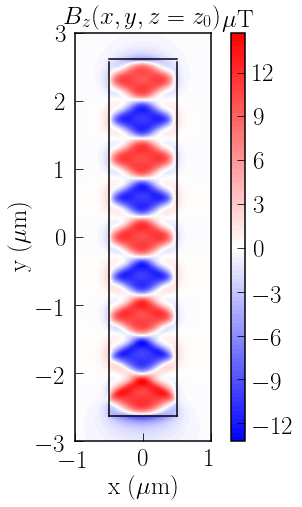

In [8]:
from matplotlib.colors import DivergingNorm

norm = .63/1.5707963267948965e-08

#pl.contourf(100*x_tmp[int(Nz/2), Ng:-Ng, Ng:-Ng], 100*y_tmp[int(Nz/2), Ng:-Ng, Ng:-Ng],
#            u_array[:, :, int(Nz/2), 0].T, 100, cmap='bwr', norm=DivergingNorm(0))
#pl.contourf(Ax_array[:, :, int(Nx/2), 0], 100, cmap='bwr', norm=DivergingNorm(0))

# im = pl.contourf(y_1d[Ng:-Ng], z_1d[Ng:-Ng], 
#                  norm*B_array[:, :, int(Nx/2), 2], 100, cmap='bwr', norm=DivergingNorm(0))

# pl.axvline(y_1d[y_index_start+Ng], color='black', ymin=.475, ymax=.525)
# pl.axvline(y_1d[y_index_start+Ng+10], color='black', ymin=.475, ymax=.525)

# pl.axvline(y_1d[y_index_end-Ng], color='black', ymin=.475, ymax=.525)

# pl.title('$B_z(x = x_0, y, z)$')

# pl.gca().set_aspect('equal')
# pl.xlim([y_1d[Ng], y_1d[-Ng]])
# pl.ylim([z_1d[Ng], z_1d[-Ng]])

# pl.xlabel('$\mathrm{y}\; (\mu \mathrm{m})$')
# pl.ylabel('$\mathrm{z}\; (\mu \mathrm{m})$')

# from mpl_toolkits.axes_grid1 import make_axes_locatable

# divider = make_axes_locatable(pl.gca())
# cax = divider.append_axes("right", "2%", pad="2%")
# pl.colorbar(im, cax=cax)

# pl.title('$\mu \mathrm{T}$')

# pl.streamplot(y_1d[Ng:-Ng], z_1d[Ng:-Ng], norm*B_array[:, :, int(Nx/2), 1], norm*B_array[:, :, int(Nx/2), 2],
#           density=2, color='black',
#           linewidth=1, arrowsize=1.5
#          )

##############################################################

im = pl.contourf(x_1d[Ng:-Ng], y_1d[Ng:-Ng], 
                 norm*B_array[int(Nz/2)+1, :, :, 2], 
                 100, cmap='bwr', norm=DivergingNorm(0)
                )


pl.title('$B_z(x, y, z=z_0)$')

pl.gca().set_aspect('equal')
#pl.xlim([y_1d[Ng], y_1d[-Ng]])
#pl.ylim([z_1d[Ng], z_1d[-Ng]])

pl.xlim([-1, 1])
pl.ylim([-3, 3])

pl.xlabel('$\mathrm{x}\; (\mu \mathrm{m})$')
pl.ylabel('$\mathrm{y}\; (\mu \mathrm{m})$')

pl.axvline(-.5, color='black', ymin=.06, ymax=.93)
pl.axvline(.5, color='black', ymin=.06, ymax=.93)
pl.axhline(y_1d[y_index_start+Ng], color='black', xmin=.25, xmax=.75)
pl.axhline(y_1d[y_index_end+Ng], color='black', xmin=.25, xmax=.75)



from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(pl.gca())
cax = divider.append_axes("right", "10%", pad="15%")
pl.colorbar(im, cax=cax)

pl.title('$\mu \mathrm{T}$')


###############################################################

# im = pl.contourf(x_1d[Ng:-Ng], z_1d[Ng:-Ng], 
#                  B_array[:, int(Ny/2), :, 2], 
#                  100, cmap='bwr', norm=DivergingNorm(0))

# pl.title('$B_z(x = x_0, y, z)$')

# pl.gca().set_aspect('equal')
# pl.xlim([x_1d[Ng], x_1d[-Ng]])
# pl.ylim([z_1d[Ng], z_1d[-Ng]])

# pl.xlabel('$\mathrm{y}\; (\mu \mathrm{m})$')
# pl.ylabel('$\mathrm{z}\; (\mu \mathrm{m})$')

# from mpl_toolkits.axes_grid1 import make_axes_locatable

# divider = make_axes_locatable(pl.gca())
# cax = divider.append_axes("right", "2%", pad="2%")
# pl.colorbar(im, cax=cax)

# pl.title('$\mu \mathrm{T}$')

# pl.streamplot(x_1d[Ng:-Ng], z_1d[Ng:-Ng], norm*B_array[:, int(Ny/2), :, 0], norm*B_array[:, int(Ny/2), :, 2],
#           density=2, color='black',
#           linewidth=1, arrowsize=1.5
#          )

#pl.savefig('Hexagonal_fermi_surface_b_Bz_x_cut.png')


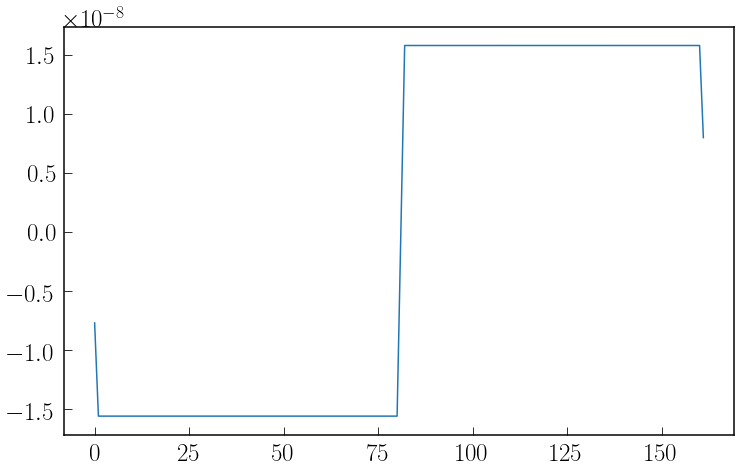

In [30]:
pl.plot(B_array[:, int(Ny/2), int(Nx/2), 1])

In [47]:
z_1d[Ng:-Ng].shape

(162,)

In [43]:
B_array[:, :, int(Nx/2), 2].shape

(162, 291)

In [244]:
current_x.max()/4.

Vec(9.69700141)